In [170]:
# Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
#import glob
import time
import os
import pickle
from skimage.feature import hog
from skimage import color, exposure
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import collections

from lessonFunctions import *

%matplotlib inline

### Dataset to lists

{'n_cars': 8792, 'data_type': dtype('uint8'), 'image_shape': (64, 64, 3), 'n_notcars': 8968}
Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


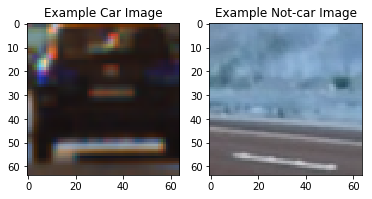

In [171]:
# from lessonFunctions import data_look

# images are divided up into vehicles and non-vehicles

imgsNon =  glob.glob('non-vehicles/*/*.png')
imgsCars =  glob.glob('vehicles/*/*.png')

cars = []
notcars = []

for impath in imgsNon:
    notcars.append(cv2.imread(impath))    

for impath in imgsCars:
    cars.append(cv2.imread(impath))
    
# sampleSize = 500
# cars = cars[0:sampleSize]
# notcars = notcars[0:sampleSize]

data_info = data_look(cars, notcars)

print(data_info)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = cars[car_ind]
notcar_image = notcars[notcar_ind]


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

plt.savefig('output_images/car_not_car.png', bbox_inches="tight")

### Classifier parameters

In [172]:
# spatial = 32 
# histBins = 32
# spatialSize = (spatial, spatial)
# histRange = (0, 256)
# colorspace = 'YUV' # Can be GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 11# HOG orientations
# pix_per_cell = 16 # HOG pixels per cell
# cell_per_block = 2
# hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
# spatial_feat = False
# hist_feat = False # Histogram features on or off
# hog_feat = True # HOG features on or off
# y_start_stop = [400, 600] # Min and max in y to search in slide_window()

spatial = 32 
histBins = 32
spatialSize = (spatial, spatial)
histRange = (0, 256)
colorspace = 'GRAY' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 14 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 4
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_feat = False
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 600] # Min and max in y to search in slide_window()

# spatial = 16 
# histBins = 16
# spatialSize = (spatial, spatial)
# histRange = (0, 256)
# colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9 # HOG orientations
# pix_per_cell = 8 # HOG pixels per cell
# cell_per_block = 2
# hog_channel = 0 # Can be 0, 1, 2, or "ALL"
# spatial_feat = True
# hist_feat = True # Histogram features on or off
# hog_feat = True # HOG features on or off
# y_start_stop = [350, 656] # Min and max in y to search in slide_window()

### Extract Features

In [173]:
t=time.time()

carFtrs = extract_features(cars, cspace=colorspace, spatial_size=spatialSize,
                        hist_bins=histBins, hist_range= histRange, orient = orient, pix_per_cell = pix_per_cell, 
                        cell_per_block = cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcarFtrs = extract_features(notcars, cspace=colorspace, spatial_size=spatialSize,
                        hist_bins=histBins, hist_range= histRange, orient = orient, pix_per_cell = pix_per_cell,
                        cell_per_block = cell_per_block,hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


print('Car features list length: ', len(carFtrs))
print('Not car features list length: ', len(notcarFtrs))


t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')



/home/pepelepoe/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Car features list length:  8792
Not car features list length:  8968
26.17 Seconds to extract features...


In [174]:
# Define array stack of feature vectors
X = np.vstack((carFtrs, notcarFtrs)).astype(np.float64)

# Define the labels vectors
y = np.hstack((np.ones(len(carFtrs)), np.zeros(len(notcarFtrs))))

In [175]:
# Split up data into randomized training and test snippets
randState = np.random.randint(0, 100)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = randState)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(Xtrain[0]))

Using: 14 orientations 8 pixels per cell and 4 cells per block
Feature vector length: 5600


In [176]:
# Fit a per-column scaler only on the training data
Xscaler = StandardScaler().fit(Xtrain)
# Apply the scaler to Xtrain and Xtest
Xtrain = Xscaler.transform(Xtrain)
Xtest = Xscaler.transform(Xtest)

# print('Using spatial binning of:', spatial, 'and', histbin, 'histogram bins')
# print('Feature vector length:', len(Xtrain[0]))

# Use a liner SVC
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
svc.fit(Xtrain, ytrain)

t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')

# Check the score  of the SVC
print('Test Accuracy of SVC = ', round(svc.score(Xtest, ytest), 4))
# Check the prediction time for a single sample
t = time.time()
nPredict = 10
print('My SVC predicts: ', svc.predict(Xtest[0:nPredict]))
print('For these', nPredict, 'labels: ', ytest[0:nPredict])

t2 = time.time()
print(round(t2 - t, 5), 'Seconds to predict ', nPredict, ' labels with SVC')


30.11 Seconds to train SVC...
Test Accuracy of SVC =  0.953
My SVC predicts:  [ 0.  1.  1.  1.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  1.  0.  0.  1.]
0.01433 Seconds to predict  10  labels with SVC


### Visualize Hog feature extraction

/home/pepelepoe/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


...


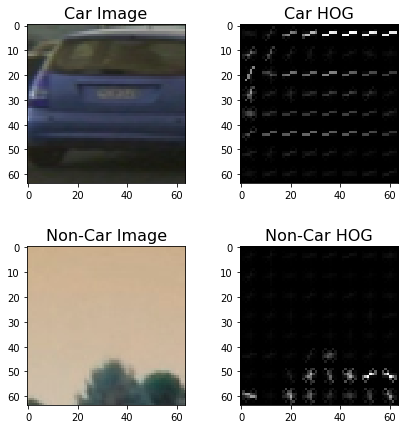

In [177]:
carImg = cars[5]
_, carDst = get_hog(carImg[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncarImg = notcars[5]
_, noncarDst = get_hog(noncarImg[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(carImg)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(carDst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncarImg)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncarDst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
plt.savefig('output_images/HOG_example.png', bbox_inches="tight")

print('...')

### Dump training data on pickle

In [178]:
from sklearn.externals import joblib
params = dict(color_space=colorspace, 
            spatial_size=spatialSize, hist_bins=histBins, 
            orient=orient, pix_per_cell=pix_per_cell, 
            cell_per_block=cell_per_block, 
            hog_channel=hog_channel, spatial_feat=spatial_feat, 
            hist_feat=hist_feat, hog_feat=hog_feat, X_scaler = Xscaler)
joblib.dump({'model':svc, 'config':params}, 'models/svc_01.pkl')

['models/svc_01.pkl']